<a href="https://colab.research.google.com/github/tojirocky/AI-workshop-/blob/main/%5BSpecial_Student%5DML_Workshop_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install timm torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.4/42.4 kB 2.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

## Create New API Token from Kaggle

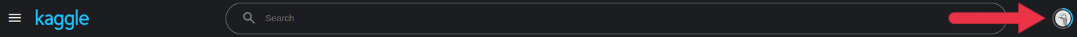

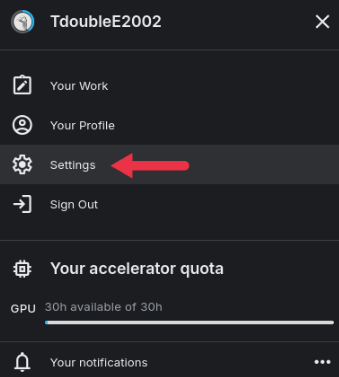

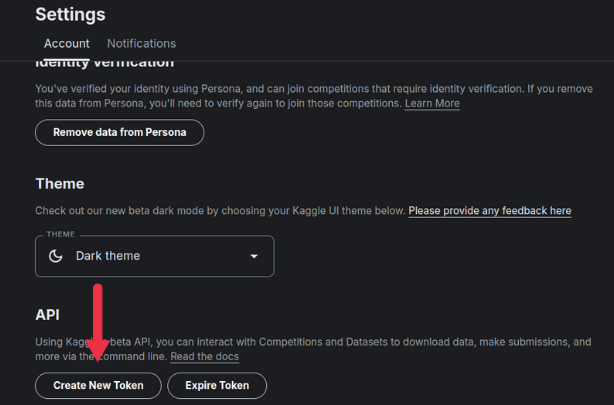

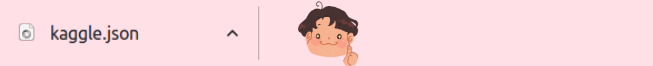

## Import Data from Kaggle

In [2]:
!pip install -q kaggle

* upload kaggle.json file

In [3]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"denpoom","key":"0971281685a031ecbdf65c9a24bbbb66"}'}

In [4]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle competitions download -c EECU-Gewertz-AI-workshop-special-01
!mkdir /content/Dataset
!unzip EECU-Gewertz-AI-workshop-special-01.zip -d /content/Dataset
!rm -rf EECU-Gewertz-AI-workshop-special-01.zip
!rm -rf kaggle.json

ref                                                           title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
spypsc07/amazon-products                                      Amazon_products                                    6KB  2024-08-02 06:13:47           1413         21  1.0              
berkayalan/paris-2024-olympics-medals                         Paris 2024 Olympics Medals                         1KB  2024-08-14 11:02:45           2746         52  1.0              
balajivaraprasad/crimes-against-women-in-india-2001-2021      Crimes Against Women in India (2001-2021)         13KB  2024-08-15 16:47:18            817         26  1.0              
haseebindata/student-performance-predictions                  Student Performance Pre

## Explore and Prepare Data

In [5]:
import os
import numpy as np
import pandas as pd
import math
import time
import random
import gc
import cv2
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Image augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Modeling
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
from torchvision.io import read_image
from torchvision.utils import make_grid
from torcheval.metrics import MulticlassAccuracy
from torch.cuda.amp import GradScaler, autocast
import timm
from joblib import load, dump

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

print(f'PyTorch version {torch.__version__}')
print(f'Albumentations version {A.__version__}')

PyTorch version 2.3.1+cu121
Albumentations version 1.4.14


In [6]:
DATA_DIR = '/content/Dataset/'
SEED = 42

### Define Helper Function

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True


# Set seed
seed_everything(SEED)


def show_gpu_memory(device):
    print(f"Allocated GPU memory: {torch.cuda.memory_allocated(device) / 1024 / 1024:.2f} MB")
    print(f"Cached GPU memory: {torch.cuda.memory_cached(device) / 1024 / 1024:.2f} MB")


def load_img(path):
    img_bgr = cv2.imread(path)
    img_rgb = img_bgr[:, :, ::-1]
    return img_rgb


def create_gallery(array, ncols=3):
    """Display multiple images in a gallery style.
    Source: https://www.amazon.co.jp/Data-Analysis-Machine-Learning-Kaggle-ebook/dp/B09F3STL34/

    Args:
        array (numpy.ndarray): array of images.
        ncols (int, optional): Num of columns. Defaults to 3.

    Returns:
        numpy.ndarray: One concatenated image.
    """
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows * ncols
    result = (array.reshape(nrows, ncols, height, width, intensity)
        .swapaxes(1,2)
        .reshape(height*nrows, width*ncols, intensity))
    return result

### Check class distribution

In [8]:
df = pd.read_csv(DATA_DIR + 'train.csv')
df.head()

,filename,label
0,003e3ac1997d44fc885426823fca31c3.jpeg,5
1,0040ae2e97414ce8ae7d02d067024361.jpeg,1
2,005a71fd86ca46028146ed130f76696f.jpeg,2
3,005edcf9bc424627934767b4a4813b31.jpeg,5
4,0074786262a84abc836810ef460cee87.jpeg,2


<Axes: title={'center': 'Label Distribution'}, xlabel='label'>

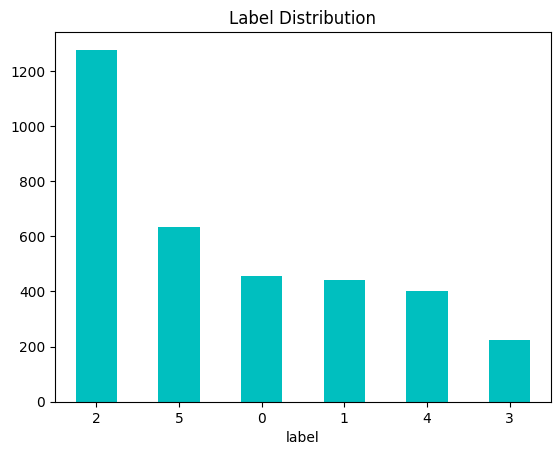

In [9]:
df['label'].value_counts().plot(kind='bar', rot=0, title='Label Distribution', color='c')

### Check Image Shape

In [10]:
img_shape = set()
img_ext = set()
img_names = Path(DATA_DIR+'train/').glob('*')
pbar = tqdm(img_names, total=len(df))
for img_name in pbar:
    img = load_img(img_name.as_posix())
    img_shape.add(img.shape)
    img_ext.add(img_name.suffix)
print(f'Image shapes are {img_shape}.')
print(f'Image extensions are {img_ext}.')

  0%|          | 0/3432 [00:00<?, ?it/s]

Image shapes are {(215, 234, 3), (225, 300, 3), (200, 139, 3), (220, 220, 3), (900, 900, 3), (480, 640, 3), (3210, 3211, 3), (397, 397, 3), (211, 239, 3), (131, 352, 3), (525, 700, 3), (425, 398, 3), (4193, 4193, 3), (189, 267, 3), (641, 640, 3), (242, 490, 3), (296, 300, 3), (140, 361, 3), (600, 600, 3), (150, 200, 3), (188, 268, 3), (3049, 3049, 3), (400, 400, 3), (560, 560, 3), (401, 500, 3), (187, 270, 3), (146, 220, 3), (194, 260, 3), (100, 100, 3), (223, 226, 3), (224, 224, 3), (199, 285, 3), (505, 785, 3), (180, 279, 3), (157, 321, 3), (3820, 3820, 3), (640, 640, 3), (205, 246, 3), (320, 320, 3), (480, 600, 3), (350, 350, 3), (194, 501, 3), (224, 225, 3), (1000, 1000, 3), (146, 346, 3), (195, 258, 3), (179, 281, 3), (450, 600, 3), (202, 250, 3), (237, 213, 3), (200, 206, 3), (228, 221, 3), (187, 501, 3), (1410, 1410, 3), (240, 210, 3), (240, 320, 3), (2851, 2851, 3), (128, 256, 3), (2369, 2369, 3), (164, 307, 3), (470, 470, 3), (260, 350, 3), (197, 200, 3), (375, 568, 3), (149, 

### Sample plot in each class

In [11]:
transform = v2.Compose([
    v2.Resize((256, 256)),
    v2.ToDtype(torch.float32, scale=True) # Convert images to PyTorch tensors
])

In [12]:
# Store unique labels and their corresponding images
unique_labels = set()
img_tensors = []
labels = []

for index, row in df.iterrows():
    if row['label'] not in unique_labels:
        img_path = Path(DATA_DIR) / 'train' / row['filename']
        image = read_image(str(img_path))
        image = transform(image)  # Ensure that the transform is applied correctly to the image tensor
        img_tensors.append(image)
        labels.append(row['label'])  # Store the label for each image
        unique_labels.add(row['label'])

    # Stop once we collect one image for each of the six classes
    if len(unique_labels) == 6:
        break

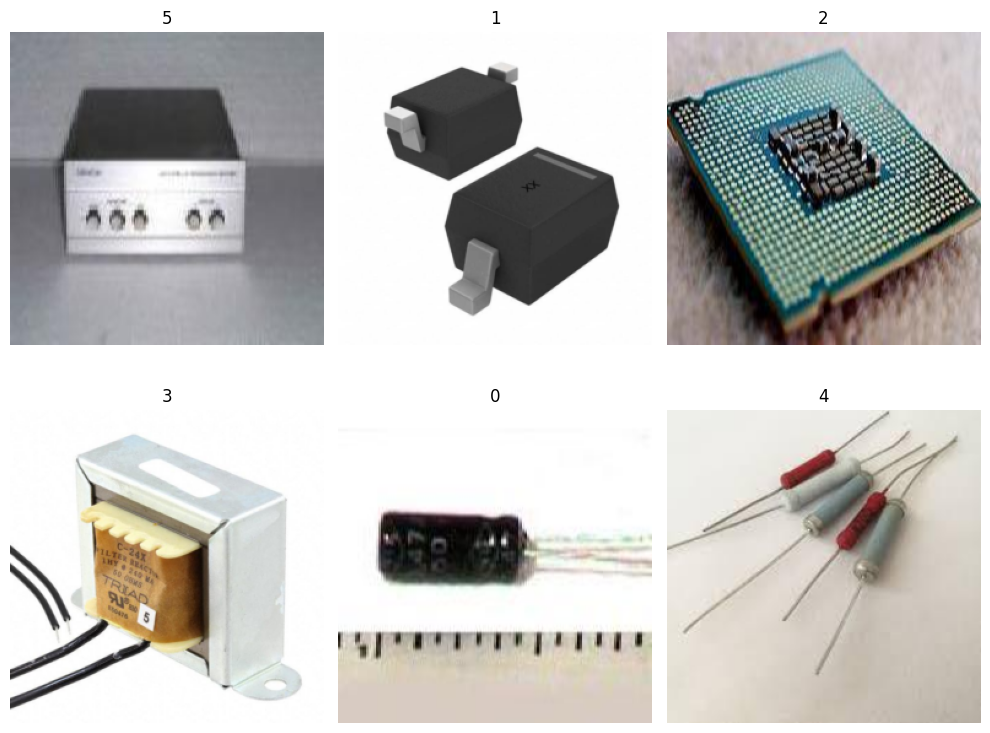

In [13]:
def show(img_tensors, labels, nrow=3):
    num_images = len(img_tensors)
    fig, axes = plt.subplots(nrows=(num_images + nrow - 1) // nrow, ncols=nrow, figsize=(10, 8))
    axes = axes.flatten()

    for i, (img_tensor, label) in enumerate(zip(img_tensors, labels)):
        axes[i].imshow(img_tensor.permute(1, 2, 0))  # Permute tensor to match image dimensions
        axes[i].set_title(label, fontsize=12)
        axes[i].axis('off')  # Turn off axis numbers and ticks

    plt.tight_layout()
    plt.show()

# Display images with their labels
show(img_tensors, labels, nrow=3)

## Build Model

### Define the Dataset


In [14]:
NORM_STATS = ((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

def transform_train():
    return A.Compose([
        A.Resize(384, 384, p=1),
        A.HorizontalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.CoarseDropout(p=0.5),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), p=1.0),
        ToTensorV2(p=1.0)
    ])

def transform_valid():
    return A.Compose([
        A.Resize(384, 384, p=1),
        A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), p=1.0),
        ToTensorV2(p=1.0)
    ])

In [15]:
# Dataset
class WorkshopDataset(Dataset):
    def __init__(self, df, data_root, transforms=None, give_label=True):
        """Performed only once when the Dataset object is instantiated.
        give_label should be False for test data
        """
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.data_root = data_root
        self.transforms = transforms
        self.give_label = give_label

        if give_label == True:
            self.labels = self.df['label'].values

    def __len__(self):
        """Function to return the number of records in the dataset
        """
        return self.df.shape[0]

    def __getitem__(self, index):
        """Function to return samples corresponding to a given index from a dataset
        """
        # get labels
        if self.give_label:
            target = self.labels[index]

        # Load images
        img  = load_img(f'{self.data_root}/{self.df.loc[index]["filename"]}').astype(np.float32)
        # img /= 255.0 # Normalization

        # Transform images
        if self.transforms:
            img = self.transforms(image=img)['image']

        if self.give_label == True:
            return img, target
        else:
            return img

### Define the DataLoader

In [16]:
BATCH_SIZE = 32
NUM_WORKERS = 8


In [17]:
def create_dataloader(df, dft, dfv):
    # Ensure that the DataFrame has a proper index
    train_ = dft.reset_index(drop=True)
    valid_ = dfv.reset_index(drop=True)

    # Ensure that the Dataset is correctly instantiated
    train_datasets = WorkshopDataset(train_, DATA_DIR+'train/', transforms=transform_train())
    valid_datasets = WorkshopDataset(valid_, DATA_DIR+'train/', transforms=transform_valid())

    # Create DataLoader objects
    train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False, pin_memory=True)

    return train_loader, valid_loader




# train *model*

In [18]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.optim import Adam

# Load a pre-trained ResNet model
net = models.resnet18(pretrained=True)

# Modify the final layer to match the number of classes in your dataset
num_classes = 6  # Replace with the actual number of classes in your dataset
net.fc = nn.Linear(net.fc.in_features, num_classes)

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = net.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = Adam(net.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 185MB/s]


In [19]:
# Ensure dft and dfv are sliced properly using iloc
dft = df.iloc[:int(3*len(df)/4)]
dfv = df.iloc[int(3*len(df)/4):]

# Assuming df is your original DataFrame
train_loader, valid_loader = create_dataloader(df, dft, dfv)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [22]:
num_epochs = 3  # Increase number of epochs

for epoch in range(num_epochs):
    net.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)

        optimizer.zero_grad()

        with autocast():
            outputs = net(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")

    net.eval()
    valid_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device, non_blocking=True), labels.to(device, non_blocking=True)
            with autocast():
                outputs = net(images)
                loss = criterion(outputs, labels)
            valid_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    accuracy = 100 * correct / total
    print(f'Validation Loss: {avg_valid_loss:.4f}, Accuracy: {accuracy:.2f}%')


print('Finished Training')

Epoch [1/5], Loss: 0.8047
Validation Loss: 1.0671, Accuracy: 62.12%
Epoch [2/5], Loss: 0.7697
Validation Loss: 0.9777, Accuracy: 69.70%
Epoch [3/5], Loss: 0.7456
Validation Loss: 1.2042, Accuracy: 57.58%
Epoch [4/5], Loss: 0.7028
Validation Loss: 1.0841, Accuracy: 65.50%
Epoch [5/5], Loss: 0.6396
Validation Loss: 1.0809, Accuracy: 64.45%
Finished Training


## Predict Submission

In [24]:
submission_df = pd.read_csv(DATA_DIR+'sample_submission.csv')

In [25]:
test_datasets = WorkshopDataset(submission_df, DATA_DIR+'test/', transforms=transform_valid(), give_label=False)
test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [26]:
print(f'==========Start Inference==========')
with torch.no_grad():
    test_preds = []
    pbar = tqdm(enumerate(test_loader), total=len(test_loader))
    for step, img in pbar:
        img = img.to(device).float()
        test_output = net(img)
        test_preds += [torch.argmax(test_output, 1).detach().cpu().numpy()]
    test_preds = np.concatenate(test_preds)
submission_df['label'] = test_preds
submission_df

==========Start Inference==========


  0%|          | 0/19 [00:00<?, ?it/s]

,filename,label
0,00ef1d4249a84d249212472cb847aa60.jpeg,1
1,011c9c6c63bf418ba14910593dc05559.jpeg,2
2,02db3bf82c744c7ba4052d4c7b4a9f4a.jpeg,2
3,0305956b3e9742a9bd20f70c4cd5915e.jpeg,5
4,035eeb8972bb496bb4f2736af86c5717.jpeg,2
...,...,...
601,fd1241efb9dc41daad714262ef8d600e.jpeg,1
602,fd45ab69c19d4b35b233d7420f4eb929.jpeg,2
603,fe06e8bf3250495abf6243d352bd60cc.jpeg,2
604,feffa323c4244bcd935b4141818237e7.jpeg,3


In [27]:
submission_df.to_csv('submission.csv', index=False)

In [33]:

import os


os.environ['KAGGLE_USERNAME'] = 'denpoom'
os.environ['KAGGLE_KEY'] = '0971281685a031ecbdf65c9a24bbbb66'

path ='/content/submission.csv'
os.system(f"kaggle competitions submit -c eecu-gewertz-ai-workshop-special-02 -f {path} -m 'Message'")

0